# Cell type annotation and marker genes

In this notebook we generate figures illustrating the named clusters in different splits and the expression of marker genes

Manual annotations are saved in `Pan_fetal_immune/metadata/manual_annotations`.

Marker genes are saved in GDrive at `Pan_fetal/significant_genes/marker_genes`

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

In [81]:
import re

In [2]:
import scvelo as scv
import seaborn as sns

In [3]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'
marker_genes_dir = "/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/marker genes/"

In [158]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/annotations/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


### Load collapsed annotation

Merging tables in `metadata/manual_annotation` with script `src/4_annotation/collapse_annotation.py`.

In [48]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.csv".format(t=timestamp), index_col=0)

keep_anno = ["LYMPHOID", 
             "MYELOID", 
             "MEM_PROGENITORS",
#              "STROMA"
            ]

anno_lvl_1_cols = ["anno_lvl_1_" + x for x in keep_anno]
anno_lvl_2_cols = ["anno_lvl_2_" + x for x in keep_anno]

In [49]:
for col in anno_lvl_2_cols:
    anno_obs[col] = anno_obs[col].str.upper()
for col in anno_lvl_1_cols:
    anno_obs[col] = anno_obs[col].str.upper()


### Extract maternal contaminants
to exclude

In [50]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
# mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

anno_obs = anno_obs[~anno_obs.index.isin(mat_barcodes)]

### Fix conflicts

fix conflicts with manual curation or assigning labels of closest nearest neighbors in full immune view.

In [51]:
## If annotation is unique, save as final
anno_obs["anno_lvl_2_final"] = np.nan
anno_obs.loc[(anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==1), "anno_lvl_2_final"] = anno_obs.loc[(anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==1), anno_lvl_2_cols].apply(lambda x: x[x.first_valid_index()], axis=1)

In [52]:
## Find cells with double annotation across multiple splits and save for manual revision
conflict_ixs = (anno_obs["is_annotated"]==1) & (anno_obs["is_uniquely_annotated"]==0)
double_anno_cells = anno_obs[conflict_ixs]
# double_anno_cells[anno_lvl_1_cols].drop_duplicates().to_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts.csv")
# double_anno_cells[anno_lvl_2_cols].drop_duplicates().to_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts_lvl2.csv")

In [53]:
## Reload manual conflict fixes 
conflicts_fixed = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/label_conflicts_lvl2_fixed.csv", index_col=0)

anno_obs_conflicts = anno_obs[conflict_ixs]
anno_obs_conflicts = anno_obs_conflicts.drop(["anno_lvl_2_final"], 1)
anno_obs_conflicts = anno_obs_conflicts.merge(conflicts_fixed, how="left")

In [54]:
anno_obs_conflicts.index = anno_obs[conflict_ixs].index.copy()

anno_obs.loc[conflict_ixs, "anno_lvl_2_final"] = anno_obs_conflicts["anno_lvl_2_final"]

to_fix_ixs = anno_obs_conflicts[anno_obs_conflicts.anno_lvl_2_final.isna()].index

In [72]:
## Load adata with KNN graph for HSC_immune to fix conflicts based on nearest neighbors
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s="HSC_IMMUNE"))
adata.var_names_make_unique()

anno_obs_hsc_immune = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]]

In [73]:
adata = adata[adata.obs_names.isin(anno_obs.index)]
adata.obs = anno_obs_hsc_immune.copy()

In [74]:
## Find neighbors of cells with conflicting annotation
knn_graph = adata.obsp["scvi_connectivities"]
knn_graph_double = knn_graph[adata.obs_names.isin(double_anno_cells.index),:]
knn_graph_double[knn_graph_double.nonzero()] = 1

## Find most abundant cell label in neighbors
neighbors_labels = pd.DataFrame()
n_neighbors_labels = pd.DataFrame()

annos = adata.obs["anno_lvl_2_final"].copy()

dummy_df = pd.get_dummies(annos)
dummy_mat = scipy.sparse.csr_matrix(dummy_df)

new_anno = knn_graph_double.dot(dummy_mat).toarray()
if new_anno.shape[1]==0:
    best_label = np.nan
    n_cells_best_label = np.nan
else:
    best_label = dummy_df.columns[new_anno.argmax(1)]
    n_cells_best_label = new_anno.max(1)
neighbors_labels['anno_lvl_2_final']  = best_label
n_neighbors_labels['anno_lvl_2_final']  = n_cells_best_label

neighbors_labels.index = adata.obs_names[adata.obs_names.isin(double_anno_cells.index)]
anno_obs.loc[to_fix_ixs, "anno_lvl_2_final"] = neighbors_labels.loc[to_fix_ixs]["anno_lvl_2_final"]

In [464]:
### Check the missing labels
# clusters_df = pd.read_csv(data_dir + "scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.HSC_IMMUNE.scVI_out.clustering.csv", index_col=0)

# adata.obs = pd.concat([adata.obs,clusters_df], 1)

# adata.obs[adata.obs["is_annotated"] == 0]["leiden_150"].value_counts()[0:10]

# adata.obs['leiden_150'] = adata.obs['leiden_150'].astype("category")
# sc.pl.umap(adata, color=['leiden_150'], size=5, groups=[41,42,27, 1, 46, 10, 3, 32],legend_loc="on data")

### Add stromal annotation

In [125]:
stromal_anno = pd.read_csv("../../metadata/manual_annotation/PAN.A01.v01.entire_data_normalised_log.20210429.STROMA.csv", index_col=0)

stromal_anno.index = stromal_anno.index.str.strip("_1")
stromal_anno = stromal_anno[~stromal_anno.index.isin(mat_barcodes)]

if not 'anno_lvl_1' in stromal_anno.columns:
    stromal_anno["anno_lvl_1"] = stromal_anno["anno_lvl_2"]
if not 'anno_lvl_2' in stromal_anno.columns:
    stromal_anno["anno_lvl_2"] = stromal_anno["anno_lvl_1"]
anno_obs.loc[stromal_anno.index,"anno_lvl_1_STROMA"] = stromal_anno["anno_lvl_1"]
anno_obs.loc[stromal_anno.index,"anno_lvl_2_STROMA"] = stromal_anno["anno_lvl_2"]

keep_anno.append("STROMA")

anno_cols = ["anno_lvl_1_" + a for a in keep_anno] + ["anno_lvl_2_" + a for a in keep_anno]

## Save info on missing annotations or duplicated annotations
anno_obs['is_annotated'] = anno_obs[anno_cols].notna().any(axis=1).astype("int")
anno_obs['is_uniquely_annotated'] = (anno_obs[anno_cols].notna().sum(axis=1)==2).astype("int")


anno_obs.loc[(anno_obs['is_uniquely_annotated'] == 1) & (~anno_obs['anno_lvl_2_STROMA'].isna()), "anno_lvl_2_final"] = anno_obs.loc[(anno_obs['is_uniquely_annotated'] == 1) & (~anno_obs['anno_lvl_2_STROMA'].isna()), "anno_lvl_2_STROMA"]

### Cleaning

In [143]:
import re

clean_anno = anno_obs["anno_lvl_2_final"].copy()
clean_anno = clean_anno.astype("str")
clean_anno[anno_obs["is_annotated"]==0] = "UNKNOWN"
clean_anno = [x.split(" CELL")[0] for x in clean_anno]
clean_anno = ["_".join(x.split(" ")) for x in clean_anno]
clean_anno = [re.sub("MAC$", "MACROPHAGE", x) for x in clean_anno]
clean_anno = pd.Series(clean_anno)

## Fix typos
typos = {
    'RP_MAC_(IRON_RECLYING)':'RP_MACROPHAGE_(IRON_RECYCLING)'
}

clean_anno = pd.Series([typos[x] if x in typos.keys() else x for x in clean_anno])

In [144]:
anno_obs["anno_lvl_2_final_clean"] = clean_anno.values

In [145]:
anno_obs_hsc_immune = anno_obs.loc[adata.obs_names]
adata.obs = anno_obs_hsc_immune.copy()

... storing 'file' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical
... storing 'anno_lvl_1_LYMPHOID' as categorical
... storing 'anno_lvl_2_LYMPHOID' as categorical
... storing 'anno_lvl_1_MYELOID' as categorical
... storing 'anno_lvl_2_MYELOID' as categorical
... storing 'anno_lvl_1_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_final' as categorical
... storing 'anno_lvl_2_final_clean' as categorical


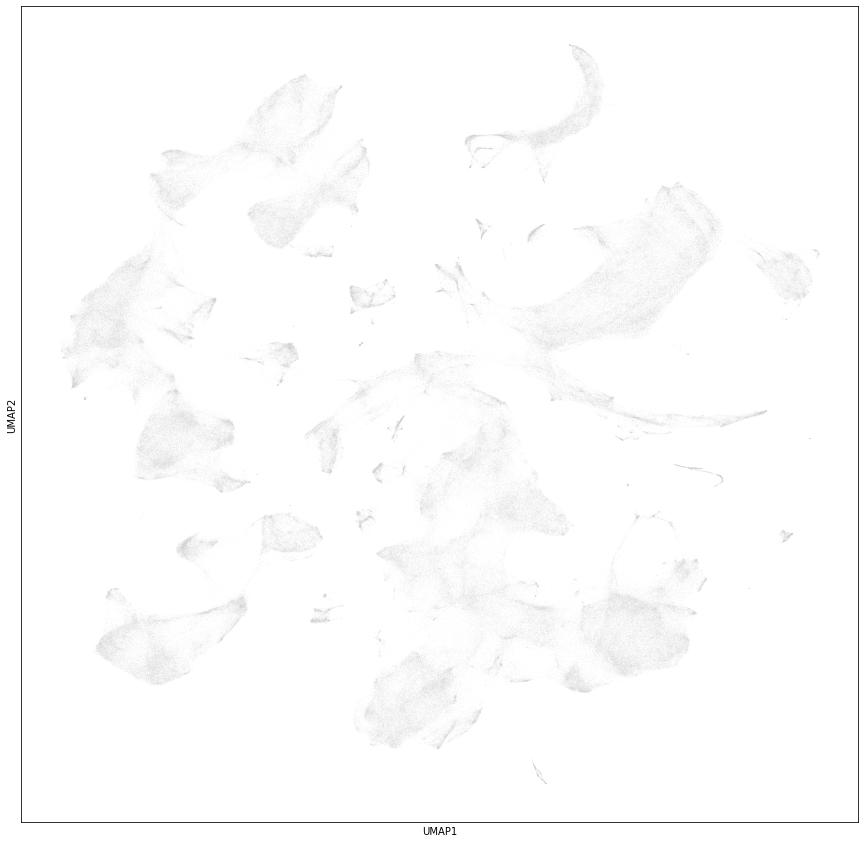

In [146]:
sc.pl.umap(adata)

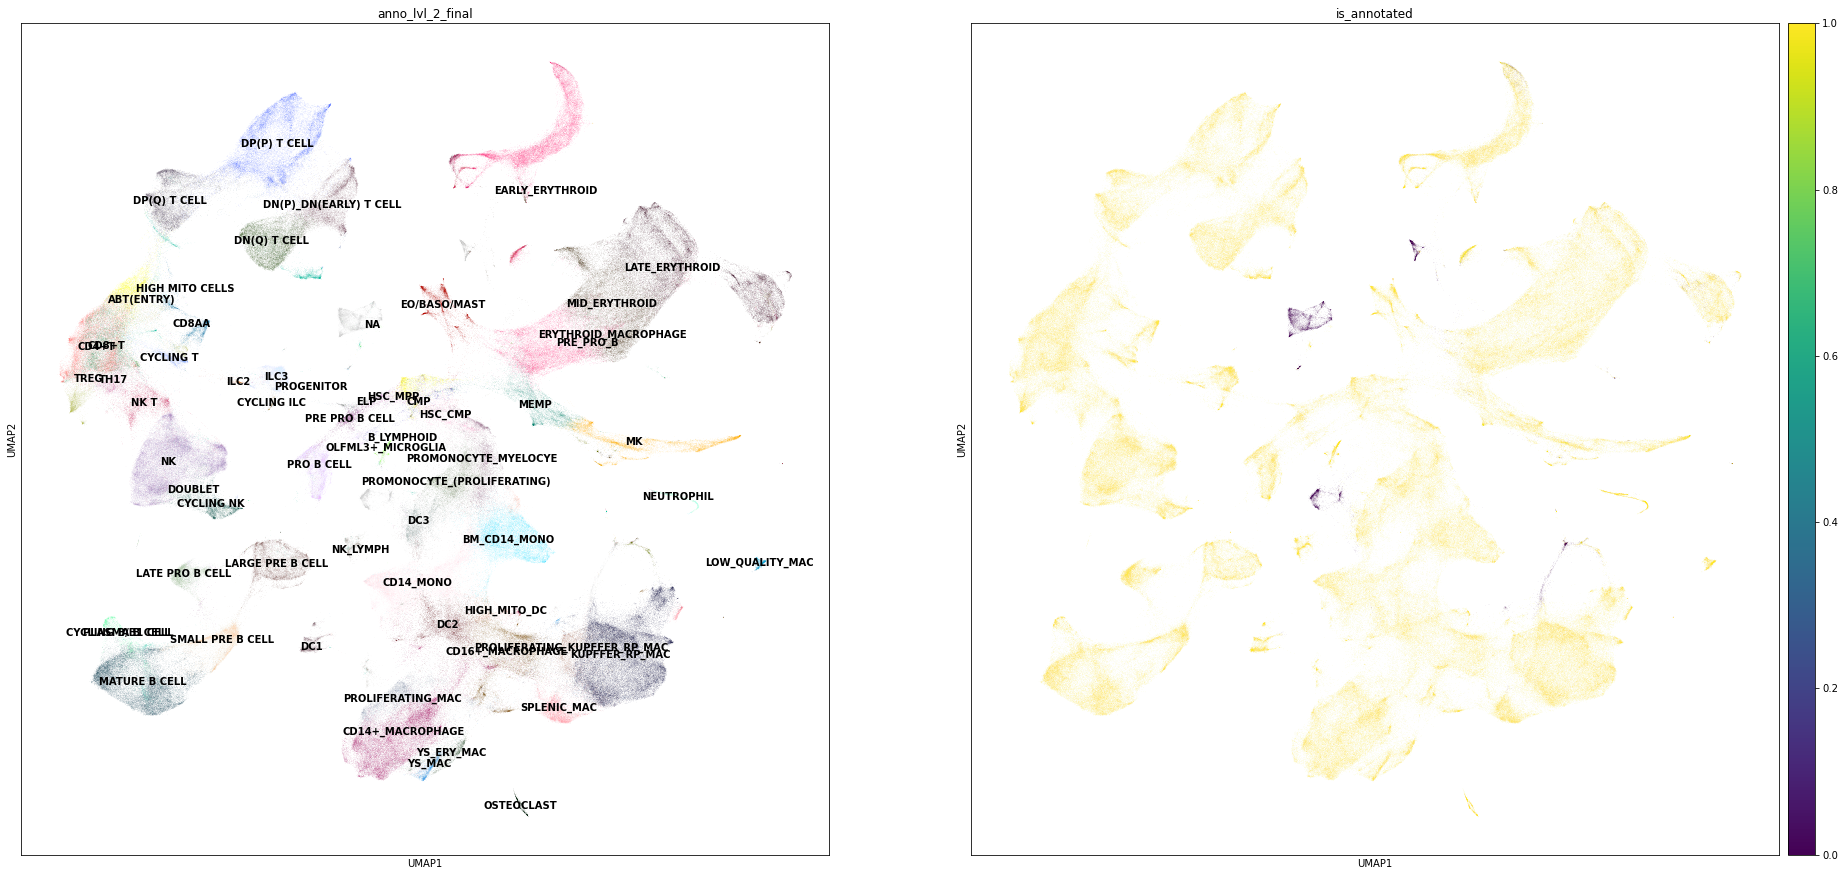

In [147]:
plt.rcParams['figure.figsize'] = [15,15]
sc.pl.umap(adata, color=['anno_lvl_2_final','is_annotated'], legend_loc="on data")

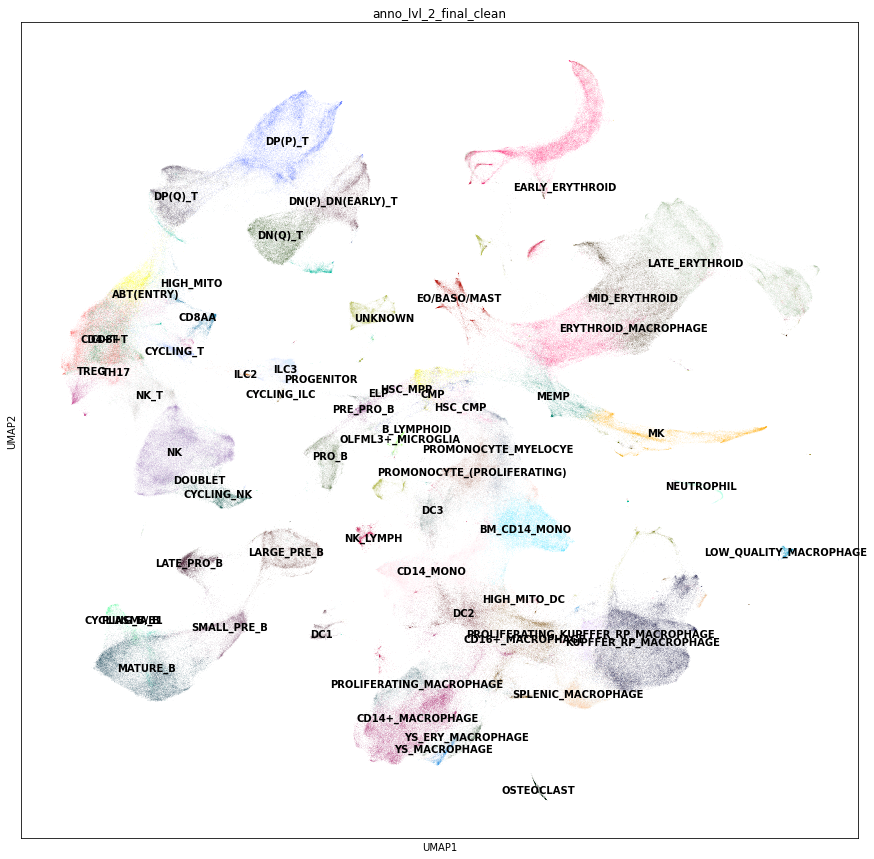

In [148]:
sc.pl.umap(adata, color=['anno_lvl_2_final_clean'], legend_loc="on data")

### Assign labels to groups
for plotting/summarisation

In [579]:
# for a in keep_anno:
#     print(anno_obs["anno_lvl_2_"+a].unique())
# ....
# ....

In [ ]:
anno_groups = {
    "NK/ILC/T CELLS" : [ "DN(P)_DN(EARLY)_T",  "DN(Q)_T", "DP(Q)_T" ,  "DP(P)_T", "ABT(ENTRY)", "CD4+T", "CD8+T", "CD8AA","TREG","TH17",  "NK_T", "NK", "ILCP","ILC2", "ILC3","CYCLING_ILC", "CYCLING_NK"],
    "B CELLS" :["PRE_PRO_B", "PRO_B","LATE_PRO_B", "PRO_TO_PRE_B","SMALL_PRE_B","LARGE_PRE_B", "PRE_B", "IMMATURE_B", "MATURE_B", "CYCLING_B/B1", "PLASMA_B"],
    "EO/BASO/MAST":["EO/BASO/MAST"],
    "MYELOID":[
    "PROMYELOCYTE","MYELOCYTE", "NEUTROPHIL",
    "MONO_MAC", "ERY_MAC", "KUPFFER", "LANGERHAN CELLS", "LYMPHOID_SCAVENGING_MAC","MAC", "MZM", "MZM_(BAFF)",
                   "RP_MAC", "STROMAL_MAC","PROMONOCYTE", "CD14_MONOCYTE",
    'PDC_PROGEN',"MYELOID_DC_PROGEN","DC_PROGEN","DC1", "DC2","DC3", "PDC"],
    "PROGENITORS" : ["HSC_MPP","CMP","MEMP","GMP","MPP_MYE","CLP", "ELP", "PROGENITOR"],
    "ERYTHROID":["EARLY_ERYTHROID","MID_ERYTHROID", "LATE_ERYTHROID","GOWER1_ERY"],
    "MK":["EARLY_MK","MK"]
    }

## Load marker genes

In [196]:
marker_genes_dir = '../../metadata/marker_genes/'
for file in [x for x in os.listdir(marker_genes_dir) if '2021.csv' in x]:
    with open(marker_genes_dir + file) as f:
        header = f.readline().rstrip()
        if "cluster" in header:
            marker_df = pd.read_csv(marker_genes_dir + file).iloc[:,0:2]
            marker_df.columns = ["anno_lvl_2", "gene"]
            marker_df = marker_df[["gene", "anno_lvl_2"]] 
        else:
            marker_df = pd.read_csv(marker_genes_dir + file, header=None).iloc[:,0:2]
            marker_df.columns = ["gene", "anno_lvl_2"]
    marker_df["anno_lvl_2"] = marker_df["anno_lvl_2"].str.upper()
    marker_df.to_csv(marker_genes_dir + file.strip(".csv") + "_clean.csv")

In [198]:
filenames = [x for x in os.listdir(marker_genes_dir) if '_clean.csv' in x]
split_names = [x.split("_")[0] for x in filenames]

all_markers_ls = []
for i in range(len(filenames)):
    marker_df = pd.read_csv(marker_genes_dir + filenames[i], index_col=0)
    marker_df["split"] = split_names[i]
    all_markers_ls.append(marker_df)

In [199]:
all_markers_df = pd.concat(all_markers_ls, 0)
all_markers_df["anno_lvl_2"] = [x.split(" CELL")[0] for x in all_markers_df["anno_lvl_2"]]
all_markers_df["anno_lvl_2"] = ["_".join(x.split(" ")) for x in all_markers_df["anno_lvl_2"]]
all_markers_df["anno_lvl_2"] = [re.sub("MAC$", "MACROPHAGE", x) for x in all_markers_df["anno_lvl_2"]]

In [200]:
all_annos = pd.concat(all_markers_ls, 0)["anno_lvl_2"].unique()
all_annos[~pd.Series(all_annos).isin(adata.obs["anno_lvl_2_final"].unique())]

array(['DN(EARLY)', 'DN(P)', 'DN(Q)', 'DP(P)', 'DP(Q)',
       'PRO TO PRE B CELL', 'IMMATURE B CELL', 'ASDC_TDC', 'ERY_MAC',
       'MZM_MAC', 'MAC', 'MONO', 'MONO_4', 'RP_MAC',
       'RP_MAC_(IRON_RECLYING)', 'PROMONOCYTE', 'FIBROBLAST',
       'SPLENIC FIBROBLAST', 'MYOFIBROBLAST', 'MUSCLE SATELLITE CELLS',
       'MESOTHELIUM', 'PERIVASCULAR MACROPHAGE', 'SKELETAL MUSCLE',
       'SMOOTH MUSCLE', 'INTERSTITIAL CELLS OF CAJAL', 'OSTEOBLAST',
       'GLIAL CELL', 'NEURON', 'MELANOCYTE', 'KERATINOCYTE', 'HEPATOCYTE',
       'DEVELOPING NEPHRON', 'EPITHELIUM', 'CYCLING EPITHELIUM',
       'CYCLING FIBROBLAST', 'ENTEROENDOCRINE CELL', 'ENDOTHELIUM',
       'VSMC/PERICYTE', 'MESENCHYMAL LYMPHOID TISSUE ORGANISER',
       'CHONDROCYTE'], dtype=object)

In [201]:
all_markers_ls

[      gene            anno_lvl_2      split
 0     C1QA  ERYTHROID_MACROPHAGE  ERYTHROID
 1     C1QB  ERYTHROID_MACROPHAGE  ERYTHROID
 2   TYROBP  ERYTHROID_MACROPHAGE  ERYTHROID
 3     C1QC  ERYTHROID_MACROPHAGE  ERYTHROID
 4     CD74  ERYTHROID_MACROPHAGE  ERYTHROID
 ..     ...                   ...        ...
 65  SYNGR1         MID_ERYTHROID  ERYTHROID
 66   PRDX2         MID_ERYTHROID  ERYTHROID
 67   HEBP1         MID_ERYTHROID  ERYTHROID
 68   KCNH2         MID_ERYTHROID  ERYTHROID
 69    AHSP         MID_ERYTHROID  ERYTHROID
 
 [70 rows x 3 columns],
       gene   anno_lvl_2 split
 0    IGLL1    DN(EARLY)   NKT
 1     ST18    DN(EARLY)   NKT
 2    TRGC2        DN(P)   NKT
 3     TRDC        DN(P)   NKT
 4   HIVEP3        DN(P)   NKT
 ..     ...          ...   ...
 87   NCAM1           NK   NKT
 88   NCAM1   CYCLING NK   NKT
 89   MKI67  CYCLING ILC   NKT
 90   MKI67    CYCLING T   NKT
 91   MKI67   CYCLING NK   NKT
 
 [92 rows x 3 columns],
       gene         anno_lvl_2 split

## Visualize clusters and markers
in lineage subsets

In [204]:
def _load_split(split, min_n_cells = 50):
    spl_adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
    spl_adata = spl_adata[~spl_adata.obs_names.isin(mat_barcodes)]
    
    ## Save annotations for split
    spl_adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[spl_adata.obs_names]["anno_lvl_2_final_clean"].astype("str")

    ## Label as OTHER cell labels that appear in less than 50 cells
    small_labels = spl_adata.obs["anno_lvl_2_final_clean"].value_counts()[spl_adata.obs["anno_lvl_2_final_clean"].value_counts() < min_n_cells].index
    spl_adata.obs.loc[spl_adata.obs["anno_lvl_2_final_clean"].isin(small_labels), "anno_lvl_2_final_clean"] = "OTHER"
    return(spl_adata)

def _plot_marker_dotplot(spl_adata, mark_split, 
                         labels_order=None, 
                         gene_labels_order=None, 
                         unique_genes=False,
                         **kwargs):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()

    markers_df= markers_df[markers_df.anno_lvl_2.isin(gene_labels_order)]
    markers_dict = {g: d['gene'].values.tolist() for g, d in markers_df.groupby('anno_lvl_2')}
    markers_dict = {k: markers_dict[k] for k in gene_labels_order}
    
    if labels_order is None:
        labels_order = gene_labels_order
    
    keep_labels = [x for x in labels_order if x in spl_adata.obs["anno_lvl_2_final_clean"].values]
    
    if unique_genes:
        markers_dict = sum(markers_dict.values(), [])
    
    sc.pl.dotplot(spl_adata[spl_adata.obs["anno_lvl_2_final_clean"].isin(keep_labels)], 
                      markers_dict, 
                      groupby="anno_lvl_2_final_clean", 
                      categories_order=keep_labels, **kwargs)
        
        
def _plot_split_embedding(spl_adata, split, **kwargs):
    sns.set_context("talk")
    scv.pl.umap(spl_adata, color="anno_lvl_2_final_clean", legend_loc="on data", 
                size=2, legend_fontoutline=3,
                title=split, **kwargs)
    
def _plot_markers_embedding(spl_adata, mark_split, n_row=5, gene_labels_order = None):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()

    markers_df= markers_df[markers_df.anno_lvl_2.isin(gene_labels_order)]
    marker_genes = markers_df.gene.unique().tolist()

    n_genes=0
    for i in range(round(len(marker_genes)/n_row) + 1):
        n_genes_max = n_row*(1+i)
        if n_genes_max > len(marker_genes):
            n_genes_max = len(marker_genes)
        sns.set_context("talk")
        print(scv.pl.umap(spl_adata, color=marker_genes[n_genes:n_genes_max], size=5, fontsize=32, legend_fontsize=32))
        n_genes += n_row
        if n_genes >= len(marker_genes):
            break

### NKT cells

In [150]:
spl_adata = _load_split("NKT")

Trying to set attribute `.obs` of view, copying.


In [728]:
nkt_labels_order = [
    'HSC_MPP',
    'MEMP',
    'HSC_CMP',
    'ELP',
    'PROGENITOR',
    'CMP',
    'DN(P)_DN(EARLY)_T',
    'DP(Q)_T',
 'DN(Q)_T',
 'DP(P)_T',
 'CYCLING_T',
 'ABT(ENTRY)',
 'CD4+T',
 'CD8+T',
  'TH17',
 'CD8AA',
 'TREG',
'NK_T',
 'NK',
 'CYCLING_NK',
 'ILC3',
 'ILC2',
 'CYCLING_ILC',
 'HIGH_MITO',
 'UNKNOWN',
 'DOUBLET']
# spl_adata.obs["anno_lvl_2_final_clean"].unique().tolist()

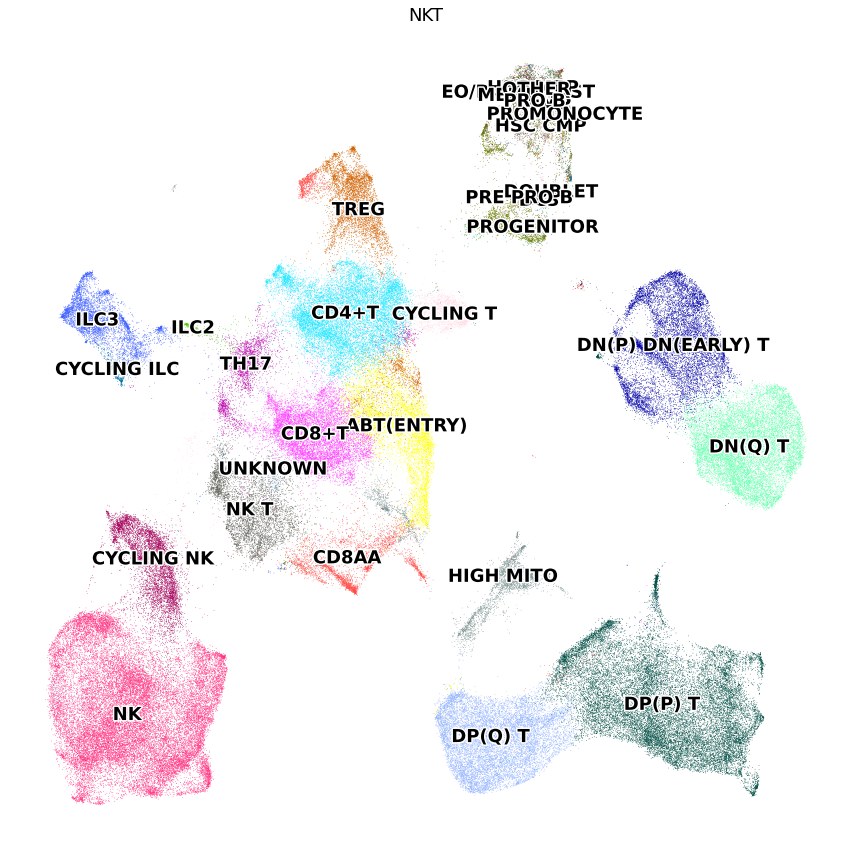

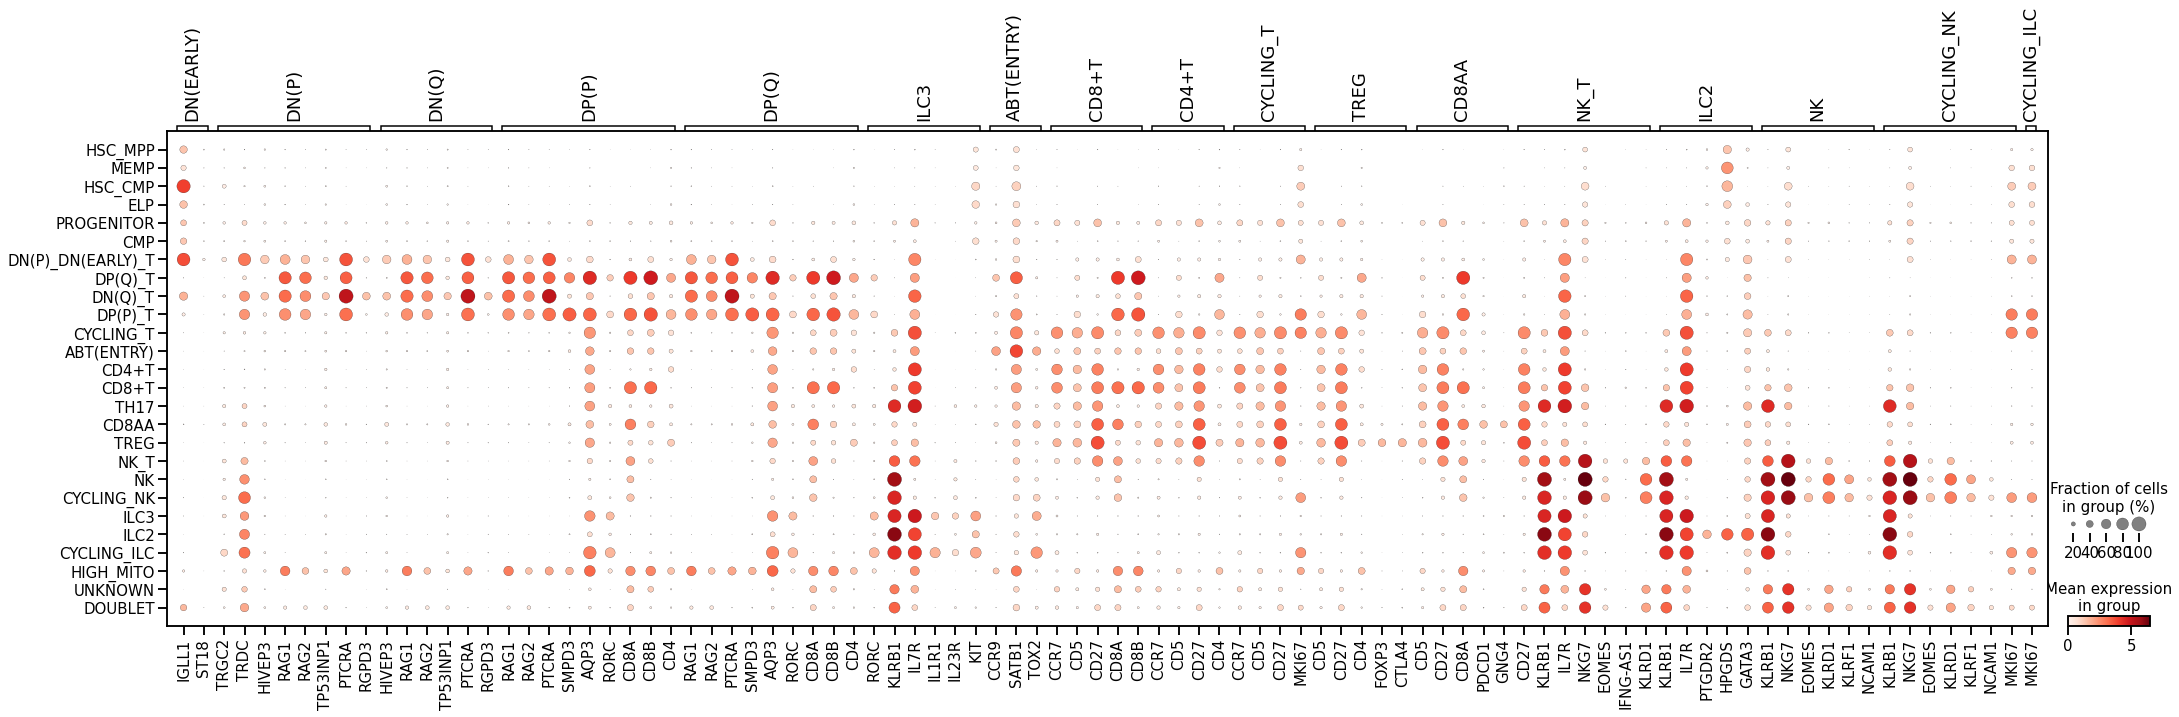

In [729]:
_plot_split_embedding(spl_adata, "NKT")
_plot_marker_dotplot(spl_adata, ["NKT"], labels_order=nkt_labels_order)
# _plot_markers_embedding(spl_adata, ["NKT"])

### Lymphoid cells

In [730]:
spl_adata = _load_split("LYMPHOID")

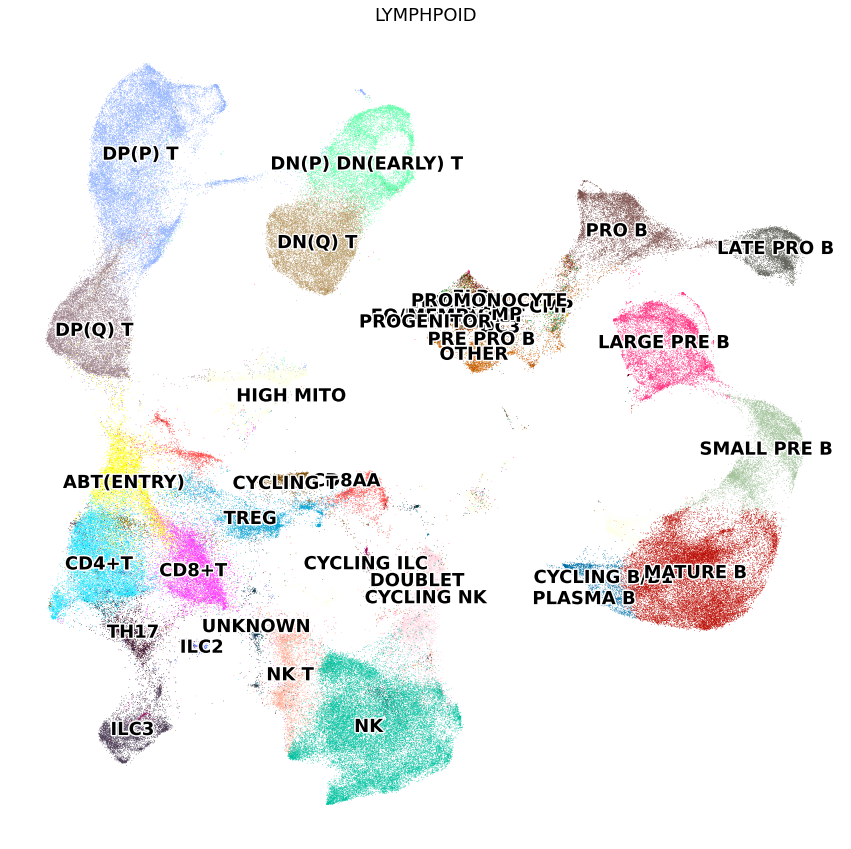

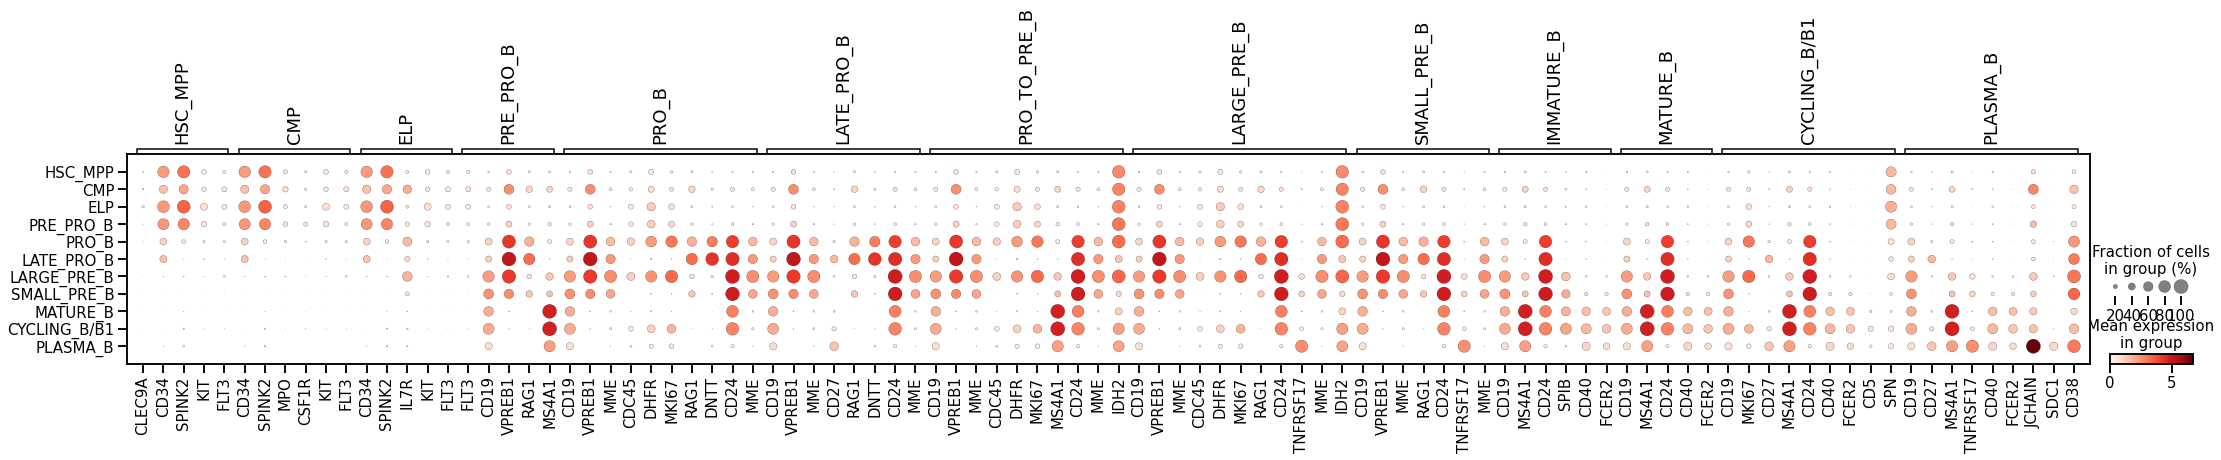

In [731]:
_plot_split_embedding(spl_adata, "LYMPHPOID")
_plot_marker_dotplot(spl_adata, ["B"])
# _plot_markers_embedding(spl_adata, ["B"])

### Myeloid cells

In [792]:
spl_adata = _load_split("MYELOID")

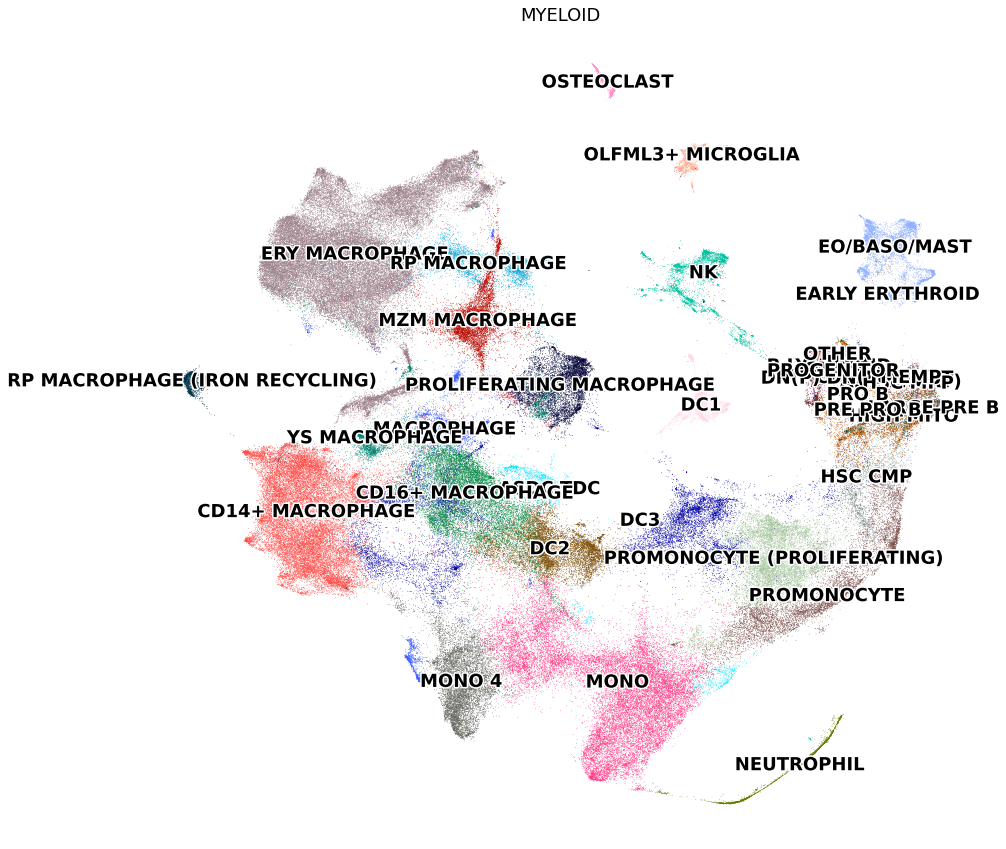

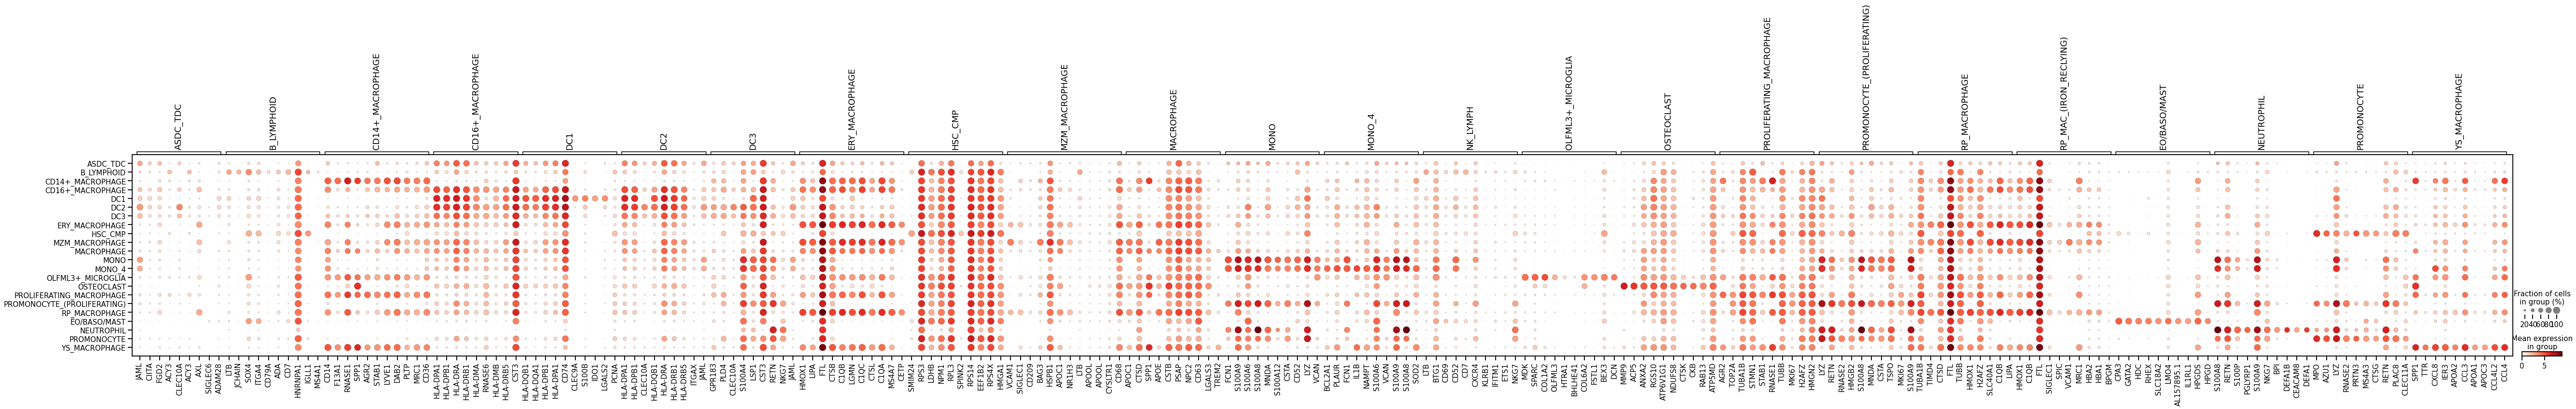

In [733]:
_plot_split_embedding(spl_adata, "MYELOID")
_plot_marker_dotplot(spl_adata, ["MYELOID"])
# _plot_markers_embedding(spl_adata, ["MYELOID"])

### Erythroid cells

In [671]:
spl_adata = _load_split("MEM_PROGENITORS")

AnnDataReadError: Above error raised while reading key '/var' of type <class 'h5py._hl.group.Group'> from /.

In [ ]:
_plot_split_embedding(spl_adata, "ERYTHROID/MK")
_plot_marker_dotplot(spl_adata, ["MEM_PROGENITORS"])

### Stromal cells

In [167]:
spl_adata = _load_split("STROMA", min_n_cells=10)

Trying to set attribute `.obs` of view, copying.


In [185]:
stroma_anno_labels = anno_obs.loc[(anno_obs['is_uniquely_annotated'] == 1) & (~anno_obs['anno_lvl_2_STROMA'].isna()), "anno_lvl_2_final_clean"].dropna().unique().tolist()

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/annotations/scvelo__anno_lvl_2_STROMA.png


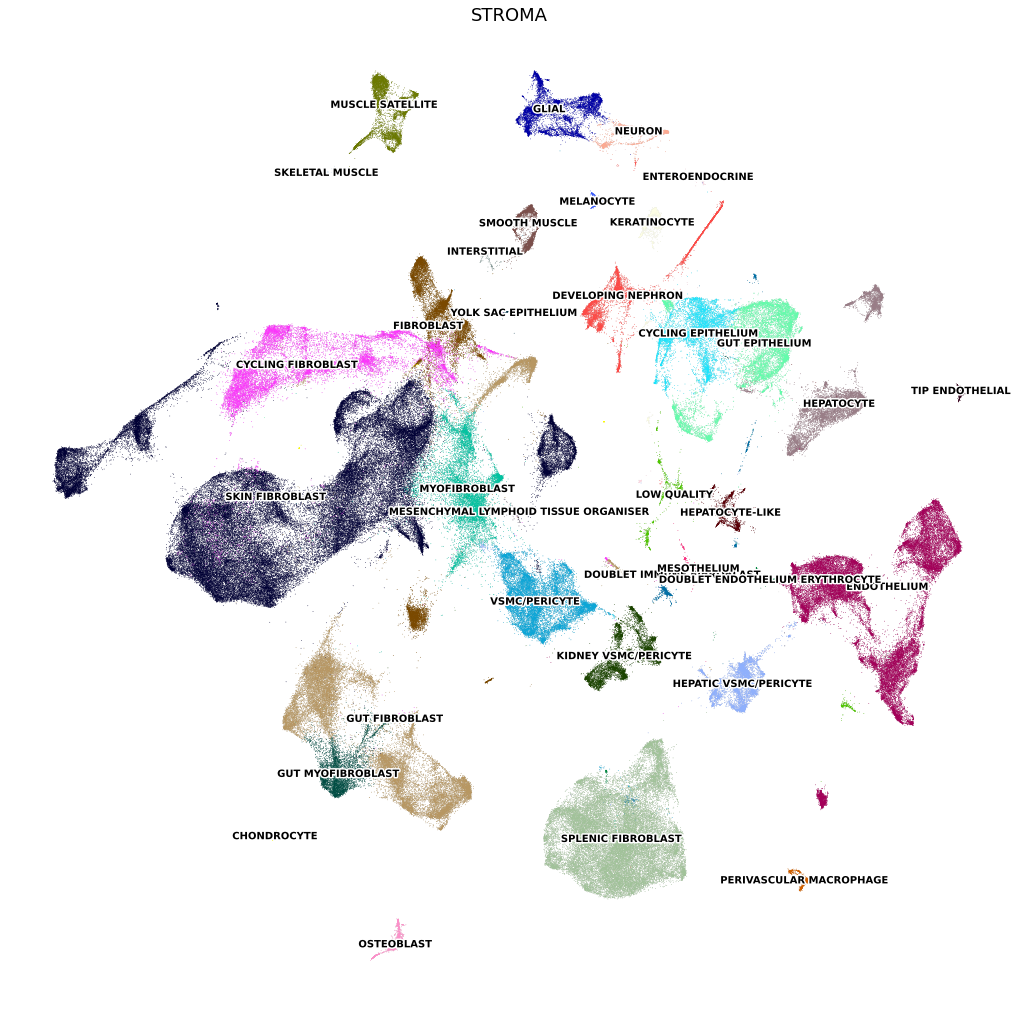

In [186]:
plt.rcParams['figure.figsize'] = [18,18]
_plot_split_embedding(spl_adata, "STROMA", save="_anno_lvl_2_STROMA.png", legend_fontsize=10, groups=stroma_anno_labels)

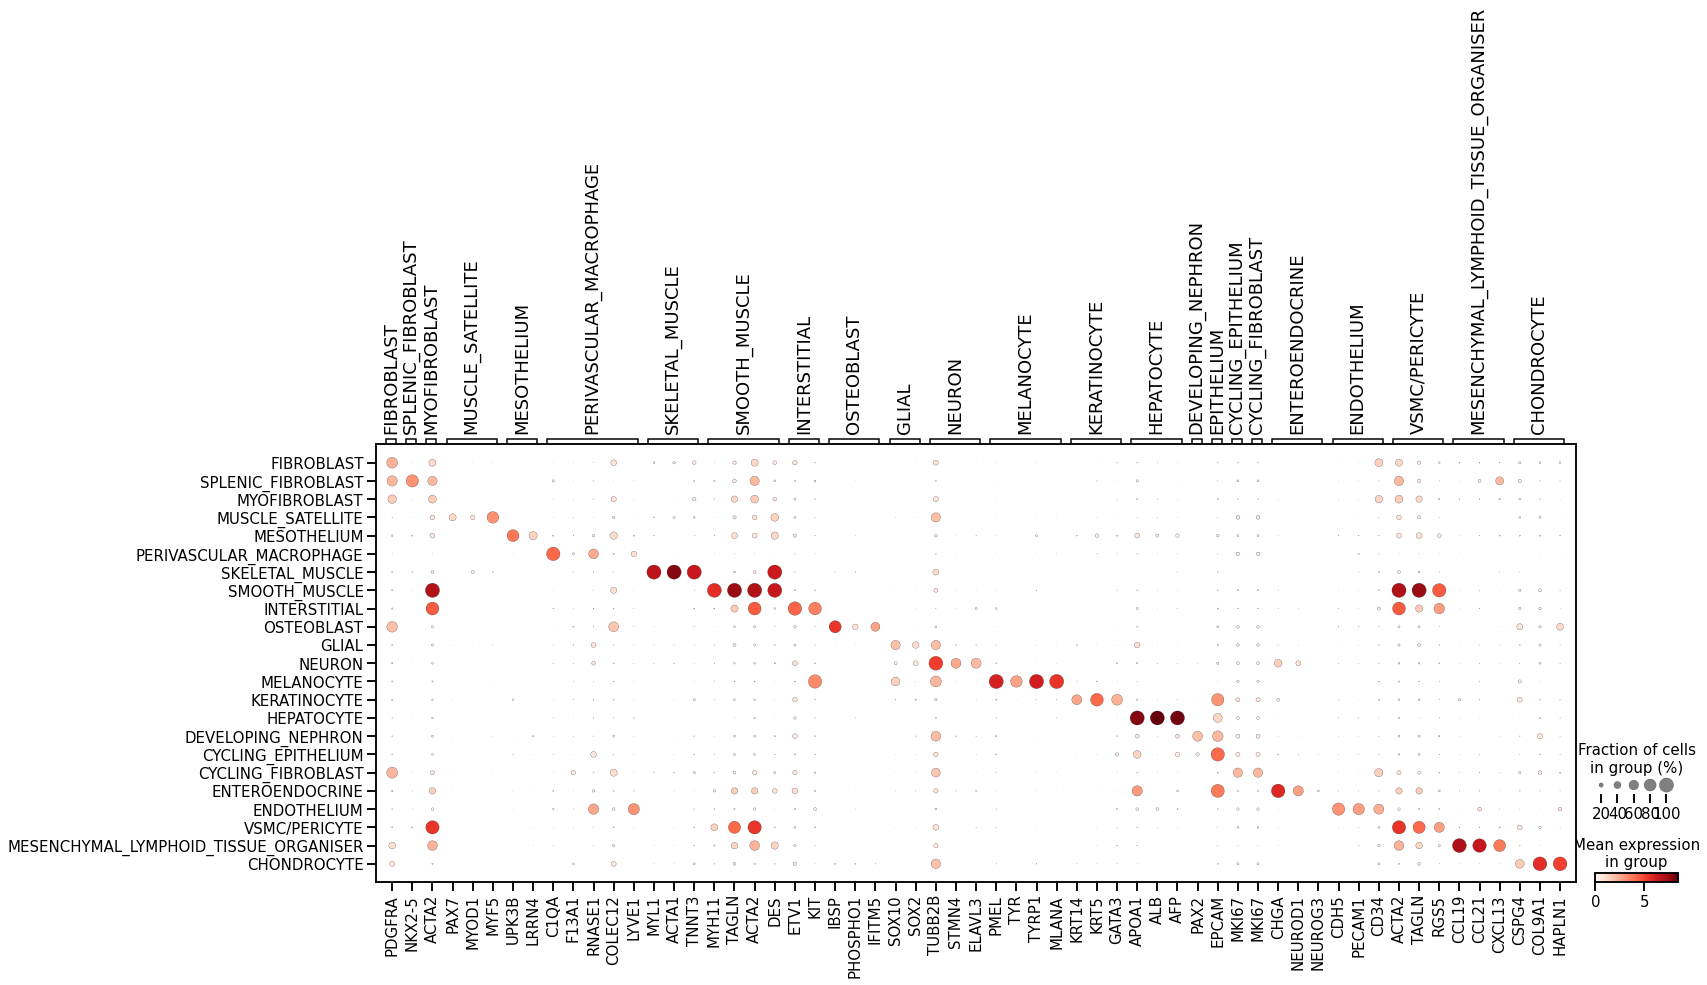

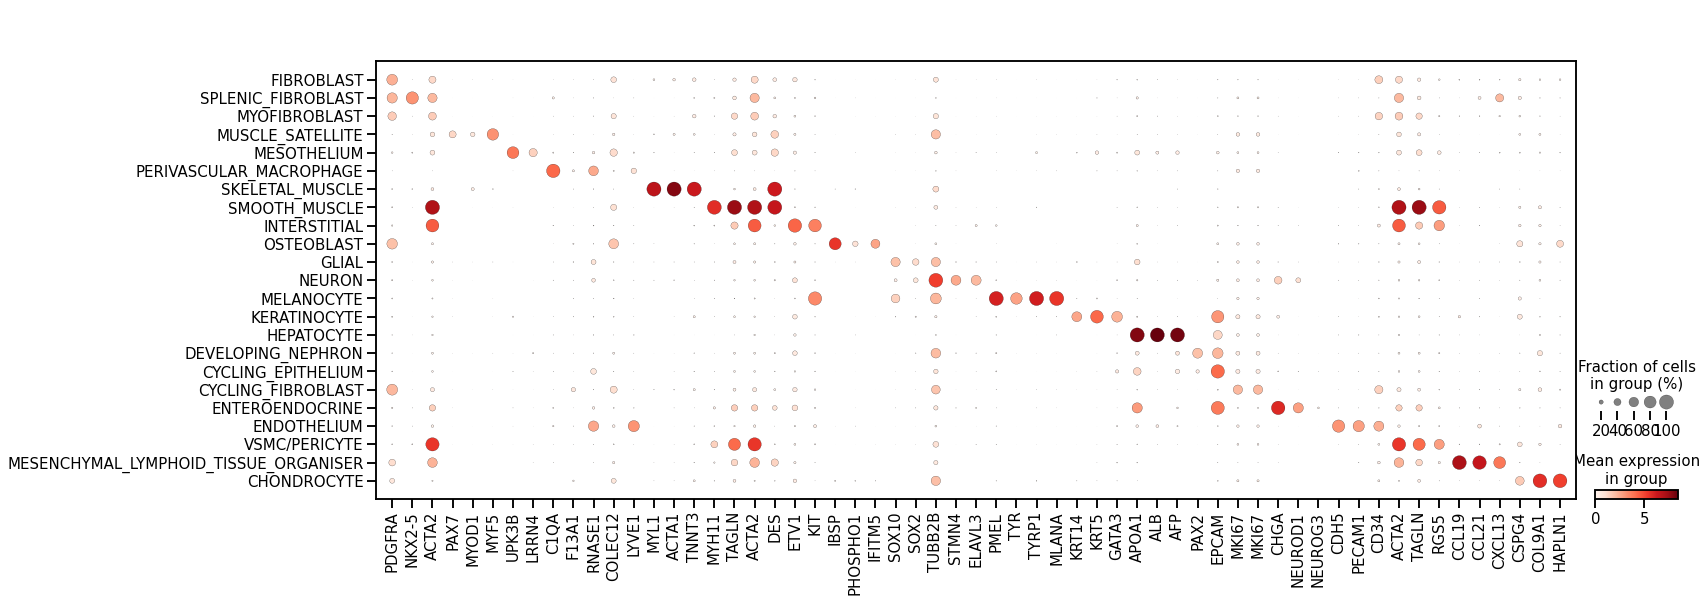

In [205]:
_plot_marker_dotplot(spl_adata, ["STROMA"], save="_anno_lvl_2_STROMA.pdf")
_plot_marker_dotplot(spl_adata, ["STROMA"], unique_genes=True, save="unique_genes_anno_lvl_2_STROMA.pdf")
# _plot_markers_embedding(spl_adata, ["MYELOID"])

## Save annotations 

In [725]:
adata.obs.to_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp))

---

In [818]:
progenitors = adata.obs_names[np.where(adata.obs[["anno_lvl_2_LYMPHOID", 'anno_lvl_2_MYELOID']].isna().sum(1)==0)]
close2progenitors_labels = ["PRE_PRO_B", 'DN(P)_DN(EARLY)_T', "MEMP", "HSC_MPP", "PROMONOCYTE", "PROMONOCYTE(PROLIFERATING)"]
close2progenitors = adata.obs_names[adata.obs.anno_lvl_2_final_clean.isin(close2progenitors_labels)]

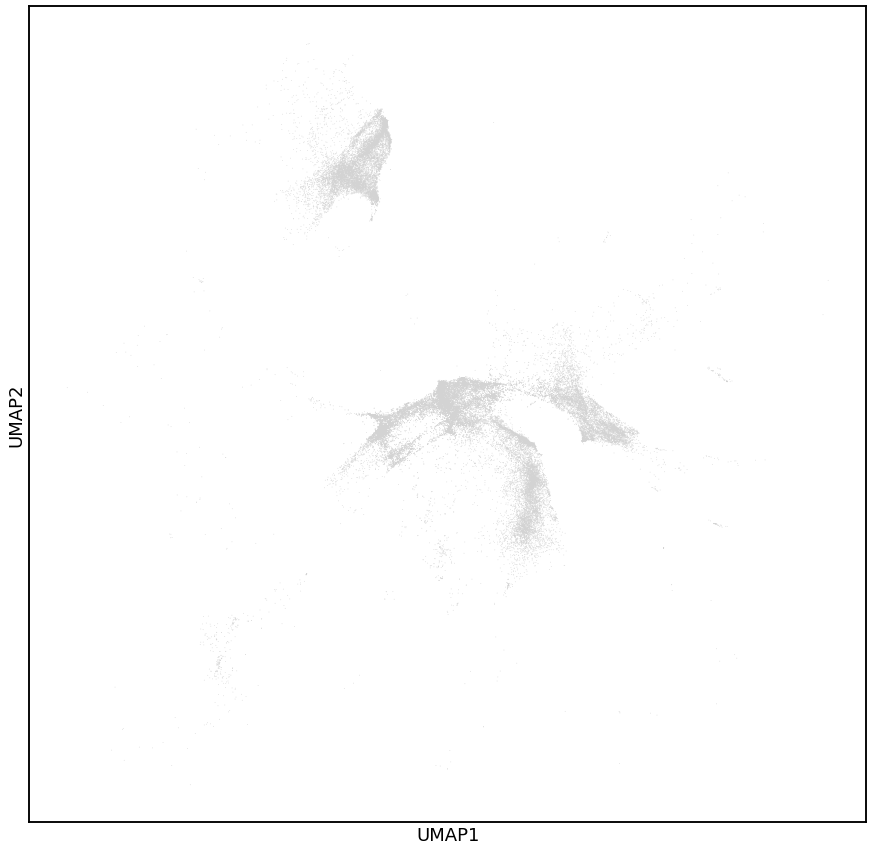

In [819]:
sc.pl.umap(adata[progenitors.append(close2progenitors)])

In [824]:
s = "HSC_PROGENITORS"

In [831]:
adata_2 = sc.read_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.HSC_IMMUNE.h5ad'.format(d=data_dir, t=timestamp))
sdata = adata_2[progenitors.append(close2progenitors).unique()]
sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [832]:
del adata_2

In [827]:
adata_raw = sc.read_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.HSC_IMMUNE.h5ad'.format(d=data_dir, t=timestamp))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [828]:
# sdata_raw = adata_raw[adata.obs["isin_" + s]==True] 
sdata_raw = adata_raw[progenitors.append(close2progenitors).unique()]
sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))

In [857]:
del adata_raw

NameError: name 'adata_raw' is not defined

---

## Outstanding issues
- "Progenitors"
- left over B_LYMPHOID
- Missing annotations for Ery subsets
